In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts"))
import auxiliar as aux
import geometry as geom

# Configuration and paths

In [2]:
# Source specifications
source_name = "crab"

# Run number
run_bad  = 6172
run_good = 3270

In [3]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/dl2_production/"
# Data main directory
root_data = root + f"../../data/cosmic_ray_data_correction/{source_name}/"

# directories for the data
dir_dl1b = root_data + "dl1b/"
dir_dl2  = root_data + "dl2/"
dir_dl3  = root_data + "dl3/"
dir_irfs = root_data + "irfs/"

# Read datacheck data

In [4]:
dcheck_good = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20201215.h5"
dcheck_bad  = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210908.h5"

dcheck_good = pd.read_hdf(dcheck_good, key="cosmics_intensity_spectrum").query(f"runnumber == {run_good}")
dcheck_bad  = pd.read_hdf(dcheck_bad,  key="cosmics_intensity_spectrum").query(f"runnumber == {run_bad}")
dcheck_good[:4]

,yyyymmdd,ra_tel,dec_tel,cos_zenith,az_tel,runnumber,subrun,time,elapsed_time,corrected_elapsed_time,cosmics_rate,cosmics_cleaned_rate,intensity_at_half_peak_rate,intensity_at_peak_rate,ZD_corrected_intensity_at_half_peak_rate,cosmics_peak_rate,ZD_corrected_cosmics_peak_rate,cosmics_rate_at_422_pe,delta_cosmics_rate_at_422_pe,ZD_corrected_cosmics_rate_at_422_pe,ZD_corrected_delta_cosmics_rate_at_422_pe,cosmics_spectral_index,delta_cosmics_spectral_index,ZD_corrected_cosmics_spectral_index,intensity_spectrum_fit_p_value,intensity_at_reference_rate,diffuse_nsb_std,num_star_affected_pixels,anomalous_low_intensity_peak
568,20201215,83.264558,21.787625,0.859349,1.664841,3270,0,1.608073e+09,10.776082,10.776082,4726.485813,4097.871459,44.467226,66.940365,43.408896,28.844706,37.966819,1.647863,0.023303,1.785560,0.025250,-2.260128,0.086991,-2.209210,0.469526,420.464205,1.773901,120,False
569,20201215,83.266563,21.787694,0.859685,1.665306,3270,1,1.608073e+09,10.856308,10.856308,4689.623978,4066.115479,45.242468,66.940365,44.168936,28.763404,37.841589,1.619586,0.015416,1.754496,0.016701,-2.337725,0.058057,-2.286945,0.768944,417.301541,1.774722,120,False
570,20201215,83.264628,21.787404,0.860052,1.665827,3270,2,1.608073e+09,10.879756,10.879756,4679.516618,4073.528775,45.766791,66.940365,44.684354,28.439886,37.395726,1.634921,0.033413,1.770641,0.036187,-2.311151,0.125410,-2.260521,0.151818,418.941179,1.773967,121,False
571,20201215,83.260643,21.787750,0.860436,1.666351,3270,3,1.608073e+09,10.839594,10.839594,4696.670319,4079.765302,44.724152,74.684021,43.669687,28.882980,37.952988,1.594936,0.022572,1.726861,0.024439,-2.388429,0.085416,-2.337957,0.482166,414.578699,1.773526,122,False


# Read 1 subrun data

In [5]:
tables = []
for srun in [0,1,2,3]:
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{srun:04}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 
    tables.append(table)

tables_good = []
for srun in [0]:
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_good:05}.{srun:04}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 
    tables_good.append(table)

## Calculate the rates and save the histogams and other data of each subrun

In [6]:
bins = np.linspace(1,5,100)
bins_c = bins[:-1] / 2 + bins[1:] / 2

histograms_good = []
histograms_bad  = []
zds_good, azs_good = [], []
zds_bad, azs_bad   = [], []
for srun, tab in enumerate(tables):
    tsrun_datacheck = dcheck_bad.query(f"subrun == {srun}")
    counts, bin_edges = np.histogram(tab["log_intensity"], bins=bins)
    rates = counts / float(tsrun_datacheck["corrected_elapsed_time"].iloc[0])
    histograms_bad.append(rates)
    
    coszd = tsrun_datacheck["cos_zenith"].iloc[0]
    zds_bad.append(np.rad2deg(np.arccos(coszd)))
    azs_bad.append(tsrun_datacheck["az_tel"].iloc[0])

for srun, tab in enumerate(tables_good):
    tsrun_datacheck = dcheck_good.query(f"subrun == {srun}")
    counts, bin_edges = np.histogram(tab["log_intensity"], bins=bins)
    rates = counts / float(tsrun_datacheck["corrected_elapsed_time"].iloc[0])
    histograms_good.append(rates)
    
    coszd = tsrun_datacheck["cos_zenith"].iloc[0]
    zds_good.append(np.rad2deg(np.arccos(coszd)))
    azs_good.append(tsrun_datacheck["az_tel"].iloc[0])

## Plot the cosmics rates

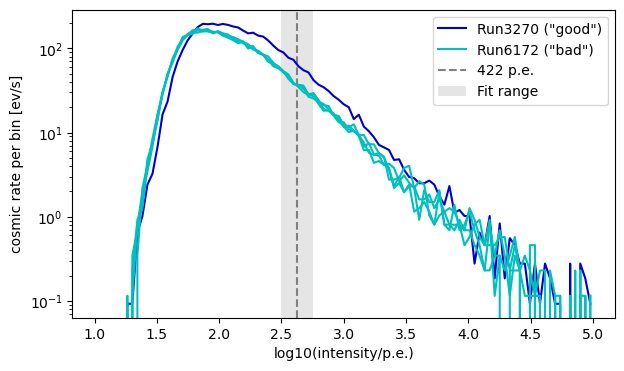

In [7]:
fig, (ax) = plt.subplots(figsize=(7,4))

for srun, tab in enumerate(tables_good):
    ax.plot(bins_c, histograms_good[srun], color="mediumblue", label=f"Run{run_good} (\"good\")" if srun == 0 else "")
    
for srun, tab in enumerate(tables):
    ax.plot(bins_c, histograms_bad[srun], color="c", label=f"Run{run_bad} (\"bad\")" if srun == 0 else "")

ax.axvline(np.log10(422), color="gray", ls="--", zorder=-1, label="422 p.e.")
ax.axvspan(np.log10(316), np.log10(562), color="gray", alpha=0.2, zorder=-2, label="Fit range", lw=0)

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")

plt.show()

RATIO = 1.6383


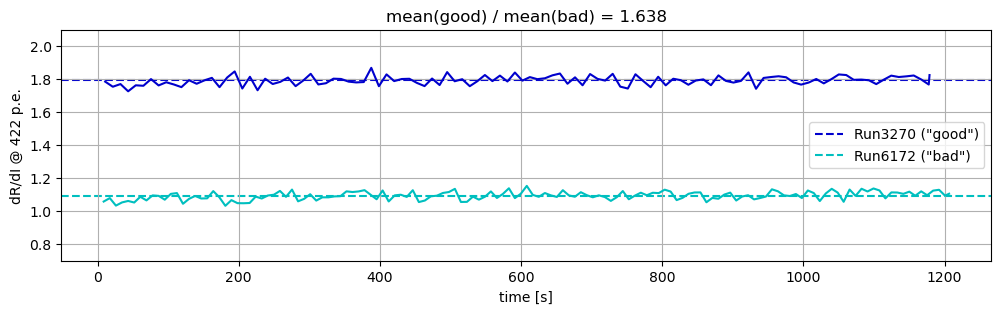

In [8]:
rate_good = np.array(dcheck_good["ZD_corrected_cosmics_rate_at_422_pe"])
rate_bad  = np.array(dcheck_bad["ZD_corrected_cosmics_rate_at_422_pe"])
elpt_good, elpt_bad = np.cumsum(dcheck_good["elapsed_time"]), np.cumsum(dcheck_bad["elapsed_time"])
ratio = np.mean(rate_good)/np.mean(rate_bad)

print(f"RATIO = {ratio:.4f}")

fig, (ax) = plt.subplots(figsize=(12,3))

ax.plot(elpt_bad, rate_bad, color="c")
ax.plot(elpt_good, rate_good, color="mediumblue")
ax.axhline(np.mean(rate_good), ls="--", zorder=-3, color="mediumblue", label=f"Run{run_good} (\"good\")")
ax.axhline(np.mean(rate_bad), ls="--", zorder=-3, color="c", label=f"Run{run_bad} (\"bad\")")

ax.legend(loc=7)
ax.set_ylabel("dR/dI @ 422 p.e.")
ax.set_xlabel("time [s]")
ax.set_ylim(0.7, 2.1)
ax.grid()
ax.set_title(f"mean(good) / mean(bad) = {ratio:.3f}")

plt.show()

In [9]:
histograms = []
# [1.0, 1.159575, 1.31915, 1.478725, 1.6383, 1.728725, 1.81915, 1.909575, 2.0]
scales = [1.0, 1.159575, 1.31915, 1.478725, 1.6383, 1.728725, 1.81915, 1.909575, 2]
cols =   ["c", "skyblue", "dodgerblue", "royalblue", "mediumblue", "darkslateblue", "darkorchid", "paletvioletred", "red"]
for scale in scales:
    ext = f"_scaled{scale:.4f}" if scale != 1.0 else ""
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{0:04}{ext}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 

    datacheck = dcheck_bad.query(f"subrun == 0")
    counts, bin_edges = np.histogram(table["log_intensity"], bins=bins)
    rates = counts / float(datacheck["corrected_elapsed_time"].iloc[0])
    histograms.append(rates)


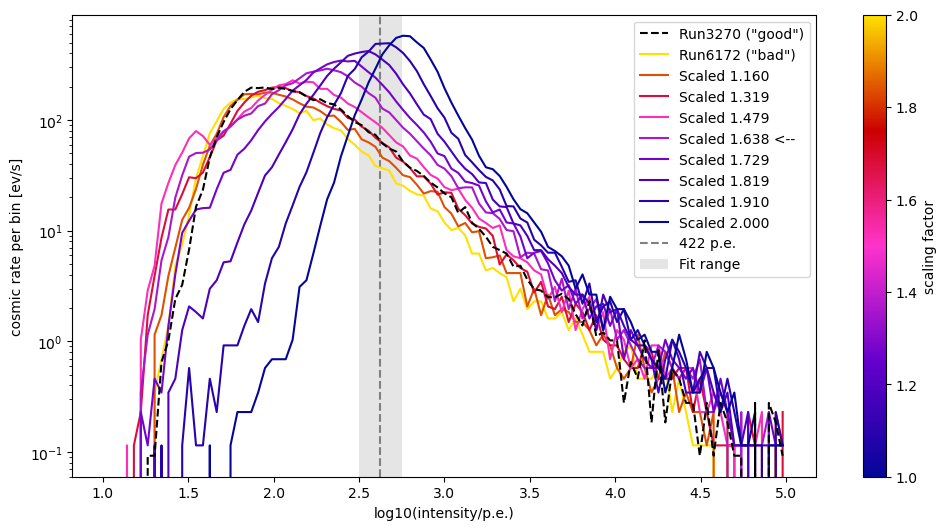

In [16]:
fig, (ax) = plt.subplots(figsize=(12,6))

for srun, tab in enumerate(tables_good):
    ax.plot(bins_c, histograms_good[srun], color="k", ls="--", label=f"Run{run_good} (\"good\")" if srun == 0 else "", zorder=100)

colors = aux.get_colors_multiplot(scales)
cmap   = aux.create_cmap(aux.predC)
aux.plot_colorbar(fig, ax, scales, cmap, label="scaling factor")

for i, scale in enumerate(scales):
    if i == 0:
        label = f"Run{run_bad} (\"bad\")"
    elif i == 4:
        label = f"Scaled {scale:.3f} <--"
    else:
        label = f"Scaled {scale:.3f}"
    ax.plot(bins_c, histograms[i], color=colors[i], label=label)

ax.axvline(np.log10(422), color="gray", ls="--", zorder=-1, label="422 p.e.")
ax.axvspan(np.log10(316), np.log10(562), color="gray", alpha=0.2, zorder=-2, label="Fit range", lw=0)

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")

plt.show()

# Calculate power law mean

In [11]:
dcheck_mask  = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_*.h5"
dcheck_files = np.sort(glob.glob(dcheck_mask))

zd_corr_cosmics_spectral_index = []
zd_corr_cosmics_at_422_pe = []
for i, f in enumerate(dcheck_files):
    if i%10 == 0:
        print(f"{i}/{len(dcheck_files)}")
    dcheck = pd.read_hdf(dcheck_fname, key="cosmics_intensity_spectrum").query(f"runnumber == {run}")
    zd_corr_cosmics_spectral_index = zd_corr_cosmics_spectral_index + list(dcheck["ZD_corrected_cosmics_spectral_index"])
    zd_corr_cosmics_at_422_pe = zd_corr_cosmics_at_422_pe + list(dcheck["ZD_corrected_cosmics_rate_at_422_pe"])


0/491


NameError: name 'dcheck_fname' is not defined

In [ ]:
# plt.hist(dcheck["ZD_corrected_cosmics_rate_at_422_pe"])

plt.hist(zd_corr_cosmics_at_422_pe, 40);

In [ ]:
dcheck

In [ ]:
dcheck_good = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210908.h5"
dcheck_bad = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210908.h5"

dcheck = pd.read_hdf(dcheck_good, key='runsummary').query(f"runnumber == {run}")
dcheck[:4]

In [ ]:
table

In [ ]:
tables = []
for srun in [0]:
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_good:05}.{srun:04}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 
    tables.append(table)

In [ ]:
datetime.fromtimestamp(tables_good[0]["dragon_time"][0])

In [ ]:
f_good = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20201215.h5"
f_bad  = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210908.h5"

dcheck_good = pd.read_hdf(f_good, key="runsummary").query(f"runnumber == {run_good}")
dcheck_bad  = pd.read_hdf(f_bad,  key="runsummary").query(f"runnumber == {run_bad}")
dcheck_good[:4]


In [ ]:
pd.read_hdf(f_bad,  key="cosmics_intensity_spectrum").query(f"runnumber == {run_bad}")